# VacationPy
---

## Starter Code to Import Libraries and Load the Weather and Coordinates Data

In [8]:
# Dependencies and Setup
import hvplot.pandas
import pandas as pd
import requests
import matplotlib.pyplot as plt


# Import API key
from api_keys import geoapify_key

In [9]:
# Load the CSV file created in Part 1 into a Pandas DataFrame
city_data_df = pd.read_csv("output_data_file/cities.csv")

# Display sample data
city_data_df



,City_ID,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,0,waitangi,-43.9535,-176.5597,281.94,89,100,1.34,NZ,1715282293
1,1,borgarnes,64.5383,-21.9206,281.18,52,100,1.48,IS,1715282294
2,2,port-aux-francais,-49.3500,70.2167,278.23,92,72,15.17,TF,1715282295
3,3,lisala,2.1500,21.5167,298.14,81,89,0.76,CD,1715282296
4,4,ust-nera,64.5667,143.2000,274.62,91,100,2.12,RU,1715282297
...,...,...,...,...,...,...,...,...,...,...
568,568,bathsheba,13.2167,-59.5167,304.49,70,20,6.69,BB,1715282839
569,569,mount pearl,47.5166,-52.7813,281.66,73,75,3.09,CA,1715282840
570,570,qarazhal,48.0078,70.7903,291.49,48,100,5.81,KZ,1715282840
571,571,gisborne,-38.6533,178.0042,284.68,63,100,10.66,NZ,1715282841


---

### Step 1: Create a map that displays a point for every city in the `city_data_df` DataFrame. The size of the point should be the humidity in each city.

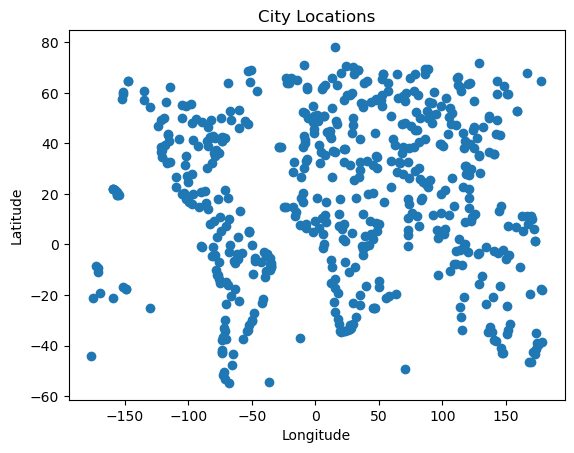

In [19]:
#map by plots, hvplots will not load, plotted per instructors guidance

plt.scatter(city_data_df["Lng"], city_data_df["Lat"])
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("City Locations")
plt.show()



### Step 2: Narrow down the `city_data_df` DataFrame to find your ideal weather condition

In [20]:
# Narrow down cities that fit criteria and drop any results with null values
ideal_cond_df = city_data_df.loc[((city_data_df["Max Temp"] <= 1000.0) & (city_data_df["Max Temp"] >= 300.0))\
                                 & (city_data_df["Cloudiness"] == 20),:]

# Drop any rows with null values
ideal_cond_df = ideal_cond_df.dropna(how="any")

# Display sample data
ideal_cond_df.head()

,City_ID,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
132,132,sao gabriel da cachoeira,-0.1303,-67.0892,303.04,79,20,1.03,BR,1715282411
289,289,fortaleza,-3.7227,-38.5247,303.27,70,20,7.72,BR,1715282566
319,319,kingston,17.9970,-76.7936,304.68,70,20,5.66,JM,1715282595
365,365,pasuquin,18.3328,120.6177,300.12,78,20,0.00,PH,1715282643
397,397,fort bragg,35.1390,-79.0060,301.38,66,20,5.14,US,1715282673


### Step 3: Create a new DataFrame called `hotel_df`.

In [21]:
%%capture --no-display
# capture added to remove false error when creating empty column

# Use the Pandas copy function to create DataFrame called hotel_df to store the city, country, coordinates, and humidity
hotel_df = ideal_cond_df[["City","Country","Lat","Lng","Humidity"]]

# Add an empty column, "Hotel Name," to the DataFrame so you can store the hotel found using the Geoapify API
hotel_df["Hotel Name"] = ""

# Display sample data
hotel_df.head()

,City,Country,Lat,Lng,Humidity,Hotel Name
132,sao gabriel da cachoeira,BR,-0.1303,-67.0892,79,
289,fortaleza,BR,-3.7227,-38.5247,70,
319,kingston,JM,17.9970,-76.7936,70,
365,pasuquin,PH,18.3328,120.6177,78,
397,fort bragg,US,35.1390,-79.0060,66,


### Step 4: For each city, use the Geoapify API to find the first hotel located within 10,000 metres of your coordinates.

In [ ]:
# Set parameters to search for a hotel
radius = 10000
params = {
    "apiKey":geoapify_key,
    "limit":10,
    "categories":"accommodation.hotel"
}

# Print a message to follow up the hotel search
print("Starting hotel search")

# Iterate through the hotel_df DataFrame
for index, row in hotel_df.iterrows():
    # get latitude, longitude from the DataFrame
    lat = row["Lat"]
    lon = row["Lng"]
    
    # Add filter and bias parameters with the current city's latitude and longitude to the params dictionary
    params["filter"] = f"circle:{lon},{lat},{radius}"
    params["bias"] = f"proximity:{lon},{lat}"
    
    # Set base URL
    base_url = "https://api.geoapify.com/v2/places"


    # Make and API request using the params dictionaty
    name_address = requests.get(base_url, params=params)
    
    # Convert the API response to JSON format
    name_address = name_address.json()
    
    # Grab the first hotel from the results and store the name in the hotel_df DataFrame
    try:
        hotel_df.loc[index, "Hotel Name"] = name_address["features"][0]["properties"]["name"]
    except (KeyError, IndexError):
        # If no hotel is found, set the hotel name as "No hotel found".
        hotel_df.loc[index, "Hotel Name"] = "No hotel found"
        
    # Log the search results
    print(f"{hotel_df.loc[index, 'City']} - nearest hotel: {hotel_df.loc[index, 'Hotel Name']}")

# Remove rows with "No hotel found"
hotel_df = hotel_df.loc[hotel_df["Hotel Name"] != "No hotel found",:]

# Display sample data
hotel_df

Starting hotel search
sao gabriel da cachoeira - nearest hotel: Hotel Deus Me Deu
fortaleza - nearest hotel: Hotel Catedral


### Step 5: Add the hotel name and the country as additional information in the hover message for each city in the map.

In [ ]:
#%%capture --no-display

# Configure the map plot
#hotel_plot = hotel_df.hvplot.points(
#    "Lng",
#    "Lat",
#    geo=True,
#    tiles="OSM",
#    frame_width=650,
#    frame_height=500,
#    size="Humidity",
#    color="City",
#    hover_cols=["Hotel Name","Country"]
#    )

# Display the map
#hotel_plot

plt.scatter(hotel_df["Lng"], hotel_df["Lat"])
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Hotel Locations")
plt.show()